In [ ]:
!ln -s /content/drive/My\ Drive/Colab\ Notebooks/myDrive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import argparse
import shutil
import os
import numpy as np

datapath1='/content/drive/My Drive/Colab Notebooks/covid-chestxray-dataset-master'
dataset_path='/content/drive/My Drive/Colab Notebooks/dataset/covid postive'



dataset=pd.read_csv(os.path.join(datapath1,'metadata.csv'))


In [ ]:

  
count=0
for(i,row ) in dataset.iterrows():
  if row["finding"] != "COVID-19" or row["view"] != "PA":
    continue
  imagePath = os.path.sep.join([datapath1, 'images',row["filename"]])
  filename = row["filename"]
  outputPath = os.path.sep.join([dataset_path, filename])
  shutil.copy2(imagePath, outputPath)
  count+=1


	

print(count)


180


creating next data set for normal xrays

In [ ]:
kageldatapath='/content/drive/My Drive/Colab Notebooks/Coronahack-Chest-XRay-Dataset'
kageldataset_path='/content/drive/My Drive/Colab Notebooks/dataset1/covid negative'


kageldataset=pd.read_csv(os.path.join(kageldatapath,'Metadata.csv'))
count=0
for(i,row ) in kageldataset.iterrows():
  
 
  if row["Label"] != "Normal" :
    continue
  print("a")
  imagePath = os.path.sep.join([kageldatapath, 'train',row["X_ray_image_name"]])
  filename = row["X_ray_image_name"]
  outputPath = os.path.sep.join([kageldataset_path, filename])
  shutil.copy2(imagePath, outputPath)
  count+=1
  if (count==180):
    break

print(count)

preprocessing the dataset


In [ ]:
from imutils import paths
import cv2
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


dataset_path='/content/drive/My Drive/Colab Notebooks/dataset'
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []

for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]
  
  if (label not in ['covid negative','covid postive']):
    continue
  
  image = cv2.imread(imagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, (224, 224)) 
  data.append(image)
  labels.append(label)

data = np.array(data) / 255.0
data=np.reshape(data,(data.shape[0],224,224,1))
print(data.shape)

labels = np.array(labels)
print(labels[:1])
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print(labels[:1])

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")



 
	
	




(358, 224, 224, 1)
['covid postive']
[[0. 1.]]


In [ ]:
print (data.shape)

(358, 224, 224, 1)


#model training

In [ ]:
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D,Activation,MaxPooling2D
from keras.utils import normalize
from keras.layers import Concatenate
from keras import Input
from keras.callbacks import ModelCheckpoint

input_shape=data.shape[1:] 
print(input_shape)
inp=Input(shape=input_shape)
convs=[]

parrallel_kernels=[3,5,7]

for k in range(len(parrallel_kernels)):

    conv = Conv2D(128, parrallel_kernels[k],padding='same',activation='relu',input_shape=input_shape,strides=1)(inp)
    convs.append(conv)

out = Concatenate()(convs)
conv_model = Model(inp,out)

model = Sequential()
model.add(conv_model)

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,input_dim=128,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

(224, 224, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 224, 224, 384)     11008     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 222, 222, 64)      221248    
_________________________________________________________________
activation (Activation)      (None, 222, 222, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54

In [ ]:
import tensorflow as tf

H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=32),
	steps_per_epoch=len(trainX) // 32,
	validation_data=(testX, testY),
	validation_steps=len(testX) // 32,
	epochs=20)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
8/8 [==============================] - 14s 709ms/step - loss: 0.9453 - accuracy: 0.4814 - val_loss: 0.6614 - val_accuracy: 0.5000
Epoch 2/20
8/8 [==============================] - 3s 353ms/step - loss: 0.6346 - accuracy: 0.6519 - val_loss: 0.4681 - val_accuracy: 0.9167
Epoch 3/20
8/8 [==============================] - 3s 337ms/step - loss: 0.4586 - accuracy: 0.8295 - val_loss: 0.1978 - val_accuracy: 0.9306
Epoch 4/20
8/8 [==============================] - 3s 337ms/step - loss: 0.3153 - accuracy: 0.8484 - val_loss: 0.2044 - val_accuracy: 0.9167
Epoch 5/20
8/8 [==============================] - 3s 338ms/step - loss: 0.1692 - accuracy: 0.9359 - val_loss: 0.1642 - val_accuracy: 0.9306
Epoch 6/20
8/8 [==============================] - 3s 339ms/step - loss: 0.1916 - accuracy: 0.9371 - val_loss: 0.2321 - val_accuracy: 0.9167
Epoch 7/20
8/8 [==============================] - 3s 338ms/step - loss: 0.1390 - accuracy: 0.9427 - val_loss: 0.0248 - val_accuracy: 0.9861
Epoch 8/20
8/8 [===

In [ ]:


model.save('/content/drive/My Drive/Colab Notebooks/model/model_save.h5',save_format='h5')

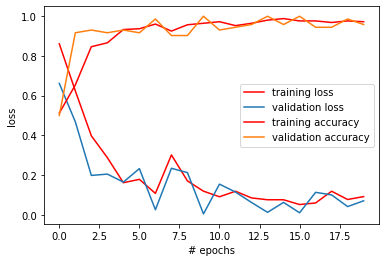

In [ ]:
from matplotlib import pyplot as plt

plt.plot(H.history['loss'],'r',label='training loss')
plt.plot(H.history['val_loss'],label='validation loss')
plt.plot(H.history['accuracy'],'r',label='training accuracy')
plt.plot(H.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

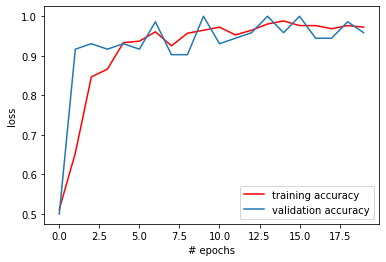

In [ ]:
plt.plot(H.history['accuracy'],'r',label='training accuracy')
plt.plot(H.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
predIdxs = model.predict(testX, batch_size=32)


predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

                precision    recall  f1-score   support

covid negative       0.95      0.97      0.96        36
 covid postive       0.97      0.94      0.96        36

      accuracy                           0.96        72
     macro avg       0.96      0.96      0.96        72
  weighted avg       0.96      0.96      0.96        72



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[35  1]
 [ 2 34]]
acc: 0.9583
sensitivity: 0.9722
specificity: 0.9444
